In [90]:
import sympy
import symfem
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify
import dill
dill.settings["recurse"] = True
from sympy import Rational as R
from tqdm.notebook import tqdm

## Define necessary symbols

In [69]:
x, y, p, q = sympy.symbols("x y p q")
x1, x2, x3, x4, x5, x6 = sympy.symbols("x1:7")
y1, y2, y3, y4, y5, y6 = sympy.symbols("y1:7")
s = sympy.symbols("s")

## Get shape functions

In [70]:
monomial_basis = sympy.Matrix([
    1,
    x,
    x**2,
    x**3,
    y,
    y**2,
    y**3,
    x*y,
    x*y**2,
    x**2*y
])

V = sympy.zeros(10, 10)

for i, basis in enumerate(monomial_basis):
    
    V[i, 0] = basis.subs({x: 0, y: 0})
    V[i, 1] = basis.subs({x: 1, y: 0})
    V[i, 2] = basis.subs({x: 0, y: 1})

    V[i, 3] = -basis.subs(y, 1-x).diff(x).subs({x: 1})
    V[i, 4] = -basis.subs(y, 1-x).diff(x).subs({x: 0})

    V[i, 5] = +basis.subs({x: 0, y:s}).diff(s).subs({s: 0})
    V[i, 6] = +basis.subs({x: 0, y:s}).diff(s).subs({s: 1})

    V[i, 7] = +basis.subs({x: s, y:0}).diff(s).subs({s: 0})
    V[i, 8] = +basis.subs({x: s, y:0}).diff(s).subs({s: 1})

    # center of mass
    V[i, 9] = basis.subs({x: R(1,3), y: R(1,3)})
new_basis = V.inv() @ monomial_basis

## Test the result on an example

In [71]:
phi = np.linspace(0, 1.5, 100)
r = 1

cx = r*np.cos(phi)
cy = r*np.sin(phi)

points = np.array([
    [0.0, 0.0],
    [cx[0], cy[0]],
    [cx[-1], cy[-1]]
])

rm = np.array([
    [0, -1],
    [1, 0]
])

v21 = points[2] - points[0]
v22 = points[2] - points[0]

v31 = points[1] - points[0]
v32 = points[1] - points[0]

# v11 = np.array([+0.5, +1.0])
# v11 /= np.linalg.norm(v11)
# v12 = np.array([-1.0, -0.5])
# v12 /= np.linalg.norm(v12)

# v11 = (rm @ v31).astype(float)
# v11 /= np.linalg.norm(v11)
# v12 = (rm @ v21).astype(float)
# v12 /= np.linalg.norm(v12)

base_angle = np.arccos(v21@v32 / np.linalg.norm(v21) / np.linalg.norm(v31))
v11 = np.array([-np.sin(phi[+0]), np.cos(phi[+0])]) * base_angle * r
v12 = np.array([-np.sin(phi[-1]), np.cos(phi[-1])]) * base_angle * r

In [72]:
X = points[0, 0]*new_basis[0] + points[1, 0]*new_basis[1] + points[2, 0]*new_basis[2] + \
    v11[0]*new_basis[3] + v12[0]*new_basis[4] + \
    v21[0]*new_basis[5] + v22[0]*new_basis[6] + \
    v31[0]*new_basis[7] + v32[0]*new_basis[8] + \
    points[:3, 0].mean()*new_basis[9]

Y = points[0, 1]*new_basis[0] + points[1, 1]*new_basis[1] + points[2, 1]*new_basis[2] + \
    v11[1]*new_basis[3] + v12[1]*new_basis[4] + \
    v21[1]*new_basis[5] + v22[1]*new_basis[6] + \
    v31[1]*new_basis[7] + v32[1]*new_basis[8] + \
    points[:3, 1].mean()*new_basis[9]


In [73]:
tt = np.linspace(0, 1, 100)
e1_x = sympy.lambdify([x, y], X)(tt, 1-tt)
e1_y = sympy.lambdify([x, y], Y)(tt, 1-tt)

e2_x = sympy.lambdify([x, y], X)(0, tt)
e2_y = sympy.lambdify([x, y], Y)(0, tt)

e3_x = sympy.lambdify([x, y], X)(tt, 0)
e3_y = sympy.lambdify([x, y], Y)(tt, 0)

## Visualization

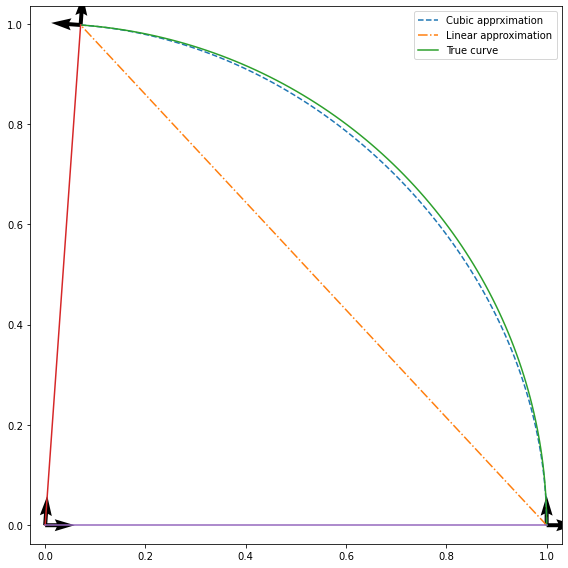

In [74]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(e1_x, e1_y, ls="--")
ax.plot([cx[0], cx[-1]], [cy[0], cy[-1]], ls="-.")
ax.plot(cx, cy)
ax.legend(["Cubic apprximation", "Linear approximation", "True curve"])

ax.plot(e2_x, e2_y)
ax.plot(e3_x, e3_y)

ax.quiver(points[1, 0], points[1, 1], v11[0], v11[1])
ax.quiver(points[2, 0], points[2, 1], v12[0], v12[1])

ax.quiver(points[0, 0], points[0, 1], v21[0], v21[1])
ax.quiver(points[2, 0], points[2, 1], v22[0], v22[1])

ax.quiver(points[0, 0], points[0, 1], v31[0], v31[1])
ax.quiver(points[1, 0], points[1, 1], v32[0], v32[1])

ax.axis("equal");
fig.tight_layout()

## Define P1 basis on the element

In [ ]:
J_ = sympy.Matrix([X, Y]).jacobian([x, y])

In [ ]:
monomial_basis = sympy.Matrix([
    1,
    x,
    y
])

V = sympy.zeros(3, 3)

for i, basis in enumerate(monomial_basis):
    
    V[i, 0] = basis.subs({x: 0, y: 0})
    V[i, 1] = basis.subs({x: 1, y: 0})
    V[i, 2] = basis.subs({x: 0, y: 1})

p1_basis = V.inv() @ monomial_basis

In [ ]:
kv = {
    x1: points[0, 0],
    x2: points[1, 0],
    x3: points[2, 0],
    y1: points[0, 1],
    y2: points[1, 1],
    y3: points[2, 1],
}

In [ ]:
grid = np.linspace(0, 1, 30)
grid_x, grid_y = np.meshgrid(grid, grid, indexing="ij")
mask = (grid_y <= 1 - grid_x)
reference_x = grid_x[mask]
reference_y = grid_y[mask]

In [ ]:
physical_x = sympy.lambdify([x, y], X.subs(kv))(reference_x, reference_y)
physical_y = sympy.lambdify([x, y], Y.subs(kv))(reference_x, reference_y)

In [65]:
iv = np.array([
    0, 1, 0
])

In [66]:
physical_z = iv@sympy.lambdify([x, y], p1_basis)(reference_x, reference_y)[:, 0]

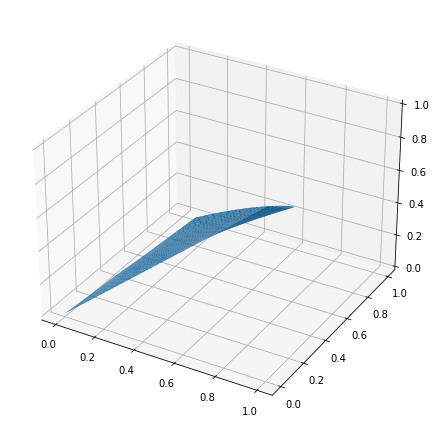

In [67]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection="3d"))
ax.plot_trisurf(physical_x, physical_y, physical_z)
fig.tight_layout()
plt.show()

In [91]:
v1x, v1y, v2x, v2y = sympy.symbols("v_{1x} v_{1y} v_{2x} v_{2y}")

X = x1*new_basis[0] + x2*new_basis[1] + x3*new_basis[2] + \
    v1x*new_basis[3] + v2x*new_basis[4] + \
    (x3-x1)*new_basis[5] + (x3-x1)*new_basis[6] + \
    (x2-x1)*new_basis[7] + (x2-x1)*new_basis[8] + \
    (x1+x2+x3)/3*new_basis[9]

Y = y1*new_basis[0] + y2*new_basis[1] + y3*new_basis[2] + \
    v1y*new_basis[3] + v2y*new_basis[4] + \
    (y3-y1)*new_basis[5] + (y3-y1)*new_basis[6] + \
    (y2-y1)*new_basis[7] + (y2-y1)*new_basis[8] + \
    (y1+y2+y3)/3*new_basis[9]


In [92]:
J = sympy.Matrix([X, Y]).jacobian([x, y])

In [87]:
dill.dump(sympy.lambdify([x1, y1, x2, y2, x3, y3, v1x, v1y, v2x, v2y, x, y], X), open("../calculations/hccex", "wb"))
dill.dump(sympy.lambdify([x1, y1, x2, y2, x3, y3, v1x, v1y, v2x, v2y, x, y], Y), open("../calculations/hccey", "wb"))

## Numerical integration

### N = 7

In [93]:
def gauss_quad_7(function):

    a, b = +0.0651301029022, +0.8697397941956
    c, d = +0.3128654960049, +0.6384441885698
    e, f = +0.0486903154253, +0.2603459660790
    g, h = +0.4793080678419, +0.0266736178044
    i, j = +0.0385568804451, +0.0878076287166
    k = -0.0747850222338

    return (
    function.subs({x:a, y:a})*h + \
    function.subs({x:b, y:a})*h + \
    function.subs({x:a, y:b})*h + \
    function.subs({x:c, y:e})*i + \
    function.subs({x:d, y:c})*i + \
    function.subs({x:e, y:d})*i + \
    function.subs({x:d, y:e})*i + \
    function.subs({x:c, y:d})*i + \
    function.subs({x:e, y:c})*i + \
    function.subs({x:f, y:f})*j + \
    function.subs({x:g, y:f})*j + \
    function.subs({x:f, y:g})*j + \
    function.subs({x:1/3, y:1/3})*k)

In [94]:
kv = {
    x1: points[0, 0],
    x2: points[1, 0],
    x3: points[2, 0],
    y1: points[0, 1],
    y2: points[1, 1],
    y3: points[2, 1],
    v1x: v11[0],
    v1y: v11[1],
    v2x: v21[0],
    v2y: v21[1],
}

In [95]:
J_inv = sympy.Matrix(
    [
        [+J[1, 1], -J[0, 1]],
        [-J[1, 0], +J[0, 0]]
    ]) / J.det()

In [106]:
N = len(p1_basis)

result_B = sympy.Matrix([[0 for i in range(N)] for j in range(N)])
result_A = sympy.Matrix([[0 for i in range(N)] for j in range(N)])

J_simp = J_inv

for idx, jdx in tqdm([(idx, jdx) for idx in range(N) for jdx in range(N)]):
    
    first = p1_basis[idx]
    second = p1_basis[jdx]

    # -----------------------U------------------------------------------------------------------------------
    u_x = first.diff(x) * J_simp.row(0)[0] + first.diff(y) * J_simp.row(1)[0]
    u_y = first.diff(x) * J_simp.row(0)[1] + first.diff(y) * J_simp.row(1)[1]
    # ------------------------------------------------------------------------------------------------------

    # -----------------------V------------------------------------------------------------------------------
    v_x = second.diff(x) * J_simp.row(0)[0] + second.diff(y) * J_simp.row(1)[0]
    v_y = second.diff(x) * J_simp.row(0)[1] + second.diff(y) * J_simp.row(1)[1]
    # ------------------------------------------------------------------------------------------------------

    # -----------------------bilinear-form------------------------------------------------------------------
    A = u_x*v_x + u_y*v_y
    B = first*second
    # ------------------------------------------------------------------------------------------------------
    
    integral_est = gauss_quad_7(A/J.det())
    result_A[idx, jdx] = integral_est

    integral_est = gauss_quad_7(B/J.det())
    result_B[idx, jdx] = integral_est
# -----------------------------------------------------------------------------------------------------

  0%|          | 0/9 [00:00<?, ?it/s]

In [107]:
right_vals = sympy.Matrix(sympy.symbols("f_1:4"))

In [108]:
FUNC_B = sympy.lambdify([x1, y1, x2, y2, x3, y3, v1x, v1y, v2x, v2y], result_B)
FUNC_A = sympy.lambdify([x1, y1, x2, y2, x3, y3, v1x, v1y, v2x, v2y, *right_vals], result_A @ right_vals)

In [109]:
dill.dump(FUNC_B, open("../calculations/lagrange_linear_poisson_matrix_curvilinear", "wb"))
dill.dump(FUNC_A, open("../calculations/lagrange_linear_poisson_right_values_curvilinear", "wb"))